# CNN Overfitting

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imgaug import augmenters as iaa

In [2]:
MODEL_ID = "cnn_of"

TRAIN_DIR = Path("../../data/train_clean")
MODEL_DIR = Path("./models")
LOG_DIR = Path("./log")
CACHE_DIR = Path("./tmp/cache")

BATCH_SIZE = 64
VAL_SPLIT = 0.25
IMG_HEIGHT = IMG_WIDTH = 200
GPU_MEMORY_LIMIT = None
SEED = 1

NUM_EPOCHS = 100
INITIAL_EPOCH = 0
LOAD_MODEL_PATH = None

In [3]:
# Remove cache directory if available
if CACHE_DIR.exists():
    shutil.rmtree(CACHE_DIR, ignore_errors = True)

MODEL_DIR.mkdir(parents = True, exist_ok = True)
LOG_DIR.mkdir(parents = True, exist_ok = True)
CACHE_DIR.mkdir(parents = True, exist_ok = True)

In [4]:
# Set global seed for reproducible results
tf.random.set_seed(SEED)

In [5]:
# Limit GPU Memory Usage to GPU_MEMORY_LIMIT
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus and GPU_MEMORY_LIMIT:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = GPU_MEMORY_LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

## Loading Images

In [6]:
X_train, X_test = train_test_split(
    list(TRAIN_DIR.glob("**/*.jpg")),
    test_size = VAL_SPLIT,
    random_state = SEED
)

train_filepaths = []
train_classes = []

val_filepaths = []
val_classes = []

for filepath in X_train:
    train_filepaths.append(str(filepath))
    train_classes.append(filepath.parts[-2])
print("Train: Found {} images belonging to {} classes".format(len(train_filepaths), len(set(train_classes))))
    
for filepath in X_test:
    val_filepaths.append(str(filepath))
    val_classes.append(filepath.parts[-2])
print("Validation: Found {} images belonging to {} classes".format(len(val_filepaths), len(set(val_classes))))
    
train_filepaths = np.array(train_filepaths)
val_filepaths = np.array(val_filepaths)

classes = np.array(train_classes + val_classes)
classes = np.unique(classes)
classes = np.sort(classes)

class_weights = class_weight.compute_class_weight("balanced", np.unique(train_classes), train_classes)

Train: Found 76660 images belonging to 42 classes
Validation: Found 25554 images belonging to 42 classes


In [7]:
train_fp_ds = tf.data.Dataset.from_tensor_slices(train_filepaths)
for f in train_fp_ds.take(3):
    print(f.numpy())

b'..\\..\\data\\train_clean\\15\\aea73be6a13ef3f176ea83af10d3a44f.jpg'
b'..\\..\\data\\train_clean\\15\\0f266821a01473426ad2a4c1eea6559b.jpg'
b'..\\..\\data\\train_clean\\22\\fda5669644e01774dee3589b6b3096ff.jpg'


In [8]:
val_fp_ds = tf.data.Dataset.from_tensor_slices(val_filepaths)
for f in val_fp_ds.take(3):
    print(f.numpy())

b'..\\..\\data\\train_clean\\41\\6c56a80536904eb7e9d9d189e9a61e40.jpg'
b'..\\..\\data\\train_clean\\28\\dc96785cf7bea661993b0149dfca0f68.jpg'
b'..\\..\\data\\train_clean\\23\\6e4d7a14361d145621d7ab5424ad766a.jpg'


In [9]:
def load_img(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == classes
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) 
    
    return img, label

In [10]:
train_img_ds = train_fp_ds.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for image, label in train_img_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  [False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [11]:
val_img_ds = val_fp_ds.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for image, label in val_img_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True]


## Image Preprocessing

In [12]:
def augment(img, label):
    def augment_inner(img, label):
        img = img.numpy()
        augmenters = iaa.OneOf([
            iaa.Affine(scale=(1.0, 1.4)),
            iaa.Affine(rotate=(-35, 35), mode="edge"),
            iaa.Affine(scale=(1.0, 1.2), rotate=(-22.5, 22.5), mode="edge"),
            iaa.LinearContrast((0.8, 1.3)),
            iaa.Sequential([iaa.Affine(scale=(1.0, 1.2)), iaa.LinearContrast((0.8, 1.3))]),
            iaa.Sequential([iaa.Affine(rotate=(-22.5, 22.5), mode="edge"), iaa.LinearContrast((0.7, 1.2))]),
            iaa.Fliplr(1),
            iaa.Sequential([iaa.Fliplr(1), iaa.Affine(rotate=(-35, 35), mode="edge")]),
            iaa.Sequential([iaa.Fliplr(1), iaa.Affine(scale=(1.0, 1.2))]),
            iaa.Sequential([iaa.Fliplr(1), iaa.Affine(scale=(1.0, 1.2), rotate=(-22.5, 22.5), mode="edge")]),
            iaa.GaussianBlur(sigma=(0.0, 1.3)),
            iaa.Cutout(nb_iterations=(1, 3), size=0.2)
        ]) 
        img = augmenters.augment_image(img)
        img = tf.clip_by_value(img, 0, 1)
        return img, label
    output = tf.py_function(augment_inner, [img, label], [tf.float32, tf.bool])
    output[0].set_shape(img.get_shape())
    output[1].set_shape(label.get_shape())
    return output

In [13]:
processed_train_ds = train_img_ds \
                        .cache(str(CACHE_DIR / "train.tfcache")) \
                        .map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE) \
                        .shuffle(BATCH_SIZE * 20, seed = SEED) \
                        .repeat() \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
processed_val_ds = val_img_ds \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.experimental.AUTOTUNE)

## Training Model

In [15]:
if not LOAD_MODEL_PATH:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size = (7, 7), strides = (2, 2), input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (5, 5)))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (3, 3)))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
    
    model.add(tf.keras.layers.Conv2D(256, kernel_size = (3, 3)))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(len(classes), activation = "softmax"))

    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.15),
        metrics = ["accuracy"]
    )
else:
    model = tf.keras.models.load_model(str(LOAD_MODEL_PATH))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 97, 64)        9472      
_________________________________________________________________
activation (Activation)      (None, 97, 97, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 128)       204928    
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 128)       5

In [17]:
checkpoint_path = MODEL_DIR / (MODEL_ID + ".{epoch:03d}-{val_accuracy:.4f}.h5")
log_path = (LOG_DIR / MODEL_ID).with_suffix(".csv")

print(checkpoint_path)
print(log_path)

models\cnn_of.{epoch:03d}-{val_accuracy:.4f}.h5
log\cnn_of.csv


In [18]:
history = model.fit(
    processed_train_ds,
    epochs = NUM_EPOCHS,
    initial_epoch = INITIAL_EPOCH,
    steps_per_epoch = len(train_filepaths) // BATCH_SIZE,
    validation_data = processed_val_ds,
    validation_steps = len(val_filepaths) // BATCH_SIZE,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True,
            verbose = 1,
            monitor = "val_accuracy",
            mode = "max"
        ),
        tf.keras.callbacks.CSVLogger(str(log_path), append = True),
        tf.keras.callbacks.ModelCheckpoint(
            str(checkpoint_path),
            monitor = "val_accuracy",
            mode = "max",
            save_best_only = True
        )
    ]
)

Epoch 1/100
1197/1197 [==============================] - 457s 382ms/step - loss: 3.5302 - accuracy: 0.1073 - val_loss: 3.2784 - val_accuracy: 0.1798
Epoch 2/100
1197/1197 [==============================] - 358s 299ms/step - loss: 3.2226 - accuracy: 0.2064 - val_loss: 3.2786 - val_accuracy: 0.1946
Epoch 3/100
1197/1197 [==============================] - 359s 300ms/step - loss: 3.0530 - accuracy: 0.2713 - val_loss: 3.2225 - val_accuracy: 0.2126
Epoch 4/100
1197/1197 [==============================] - 358s 299ms/step - loss: 2.9141 - accuracy: 0.3212 - val_loss: 2.9009 - val_accuracy: 0.3183
Epoch 5/100
1197/1197 [==============================] - 357s 298ms/step - loss: 2.8017 - accuracy: 0.3622 - val_loss: 2.7335 - val_accuracy: 0.3821
Epoch 6/100
1197/1197 [==============================] - 358s 299ms/step - loss: 2.7039 - accuracy: 0.3964 - val_loss: 2.7488 - val_accuracy: 0.3755
Epoch 7/100
1197/1197 [==============================] - 357s 298ms/step - loss: 2.6334 - accuracy: 0.4216

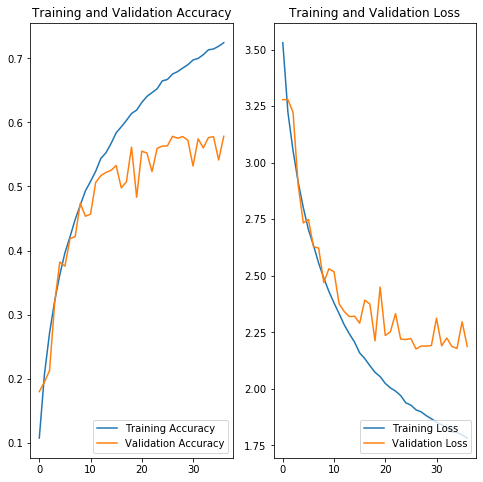

In [19]:
acc = history.history["accuracy"]
loss = history.history["loss"]
validation_acc = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

epochs_range = range(len(history.history["accuracy"]))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, validation_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, validation_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Loss")
plt.show()

In [20]:
# Remove cache directory if available
if CACHE_DIR.exists():
    shutil.rmtree(CACHE_DIR, ignore_errors = True)